In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from ucimlrepo import fetch_ucirepo 
import seaborn as sns
import copy


# Preprocessing
Dataset has 122 predictive, 5 non-predictive, 1 goal
- Remove 5 non-predictive features: state, county, community, communityname, fold
- replace missing values by NaN
- describe missing features
- remove features that has many missing values

In [3]:
  
# fetch dataset 
communities_and_crime = fetch_ucirepo(id=183) 
  
# data (as pandas dataframes) 
X = communities_and_crime.data.features 
y = communities_and_crime.data.targets 
print(X.shape, y.shape)
df = pd.concat([X, y], axis=1)
print(df.shape, df.columns)

(1994, 127) (1994, 1)
(1994, 128) Index(['state', 'county', 'community', 'communityname', 'fold', 'population',
       'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian',
       ...
       'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars', 'PolicOperBudg',
       'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn',
       'PolicBudgPerPop', 'ViolentCrimesPerPop'],
      dtype='object', length=128)


In [4]:
df = df.drop(columns=['state', 'county', 'community', 'communityname', 'fold'], axis=1)

In [5]:
# replacing missing values by NaN
# describe missing features
df = df.replace('?', np.nan)
feat_miss = df.columns[df.isnull().any()]
print(feat_miss)
print(feat_miss.shape)
df[feat_miss[0:23]].describe()

Index(['OtherPerCap', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps',
       'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop',
       'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol',
       'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian',
       'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz',
       'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr',
       'LemasGangUnitDeploy', 'PolicBudgPerPop'],
      dtype='object')
(23,)


,OtherPerCap,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,PolicBudgPerPop
count,1993,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319
unique,97,38,52,34,55,44,59,75,52,76,74,73,54,50,72,30,15,77,63,38,72,3,51
top,0,0.02,0.1,0.98,0.19,0.02,0.14,0.23,0.1,0.78,0.72,0,0,0,0.07,0.03,0.57,0.19,0.02,0.02,0.74,0,0.12
freq,129,80,19,81,17,55,23,15,19,12,11,23,72,189,14,48,54,12,27,69,13,126,22


OtherPerCap has only one missing, but others has lots of -> remove them 

In [6]:
# Impute mean values for samples with missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

imputer = imputer.fit(df[['OtherPerCap']])
df[['OtherPerCap']] = imputer.transform(df[['OtherPerCap']])

In [7]:
# drop all NaN
df = df.dropna(axis=1)
print(df.shape)
df.head()

(1994, 101)


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,...,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,...,0.06,0.14,0.13,0.33,0.39,0.28,0.55,0.09,0.51,0.5,0.21,0.71,0.52,0.05,0.26,0.65,0.14,0.06,0.22,0.19,0.18,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,...,0.10,0.16,0.10,0.17,0.29,0.17,0.26,0.20,0.82,0.0,0.02,0.79,0.24,0.02,0.25,0.65,0.16,0.00,0.21,0.20,0.21,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,...,0.04,0.20,0.20,0.46,0.52,0.43,0.42,0.15,0.51,0.5,0.01,0.86,0.41,0.29,0.30,0.52,0.47,0.45,0.18,0.17,0.16,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,0.39,0.34,0.45,...,0.08,0.56,0.62,0.85,0.77,1.00,0.94,0.12,0.01,0.5,0.01,0.97,0.96,0.60,0.47,0.52,0.11,0.11,0.24,0.21,0.19,0.75,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,0.38,0.42,0.46,0.22,0.27,...,0.05,0.16,0.19,0.59,0.60,0.37,0.89,0.02,0.19,0.5,0.01,0.89,0.87,0.04,0.55,0.73,0.05,0.14,0.31,0.31,0.30,0.40,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


### Feature selection

For linear regression, we need to have uncorrelated variables, so let's perform feature selection.

Feature selection using Pearson correlation -> only take features that have more than 0.5 correlation with the target, then remove features that are highly correlated with each other.

Index(['racepctblack', 'racePctWhite', 'pctWInvInc', 'pctWPubAsst',
       'PctPopUnderPov', 'PctUnemployed', 'MalePctDivorce', 'FemalePctDiv',
       'TotalPctDiv', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par',
       'PctTeen2Par', 'PctIlleg', 'PctPersOwnOccup', 'ViolentCrimesPerPop'],
      dtype='object')


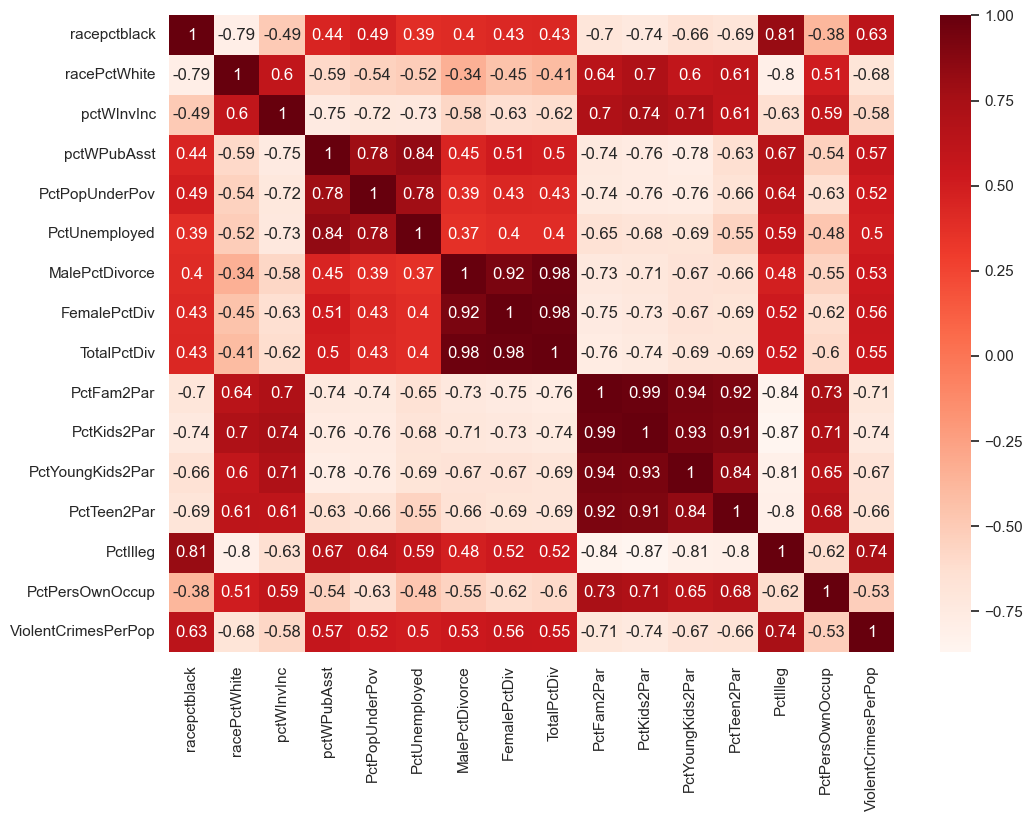

In [8]:
cor = df.corr(method="pearson")
cor_target = np.abs(cor["ViolentCrimesPerPop"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
print(relevant_features.index)

relevant_cor = df[relevant_features.index].corr(method="pearson")

sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(relevant_cor, annot=True, cmap=plt.cm.Reds)
plt.show()

We want to keep attribute racepctblack, so variables racePctWhite, and PctIlleg are dropped due to their correlation with it. 

Additionally, MalePctDivorce, FemalePctDiv, and TotalPctdiv clearly correlate -> choose TotalPctDiv and drop the others.

PctFam2Par, PctKids2Par, PctYoungKids2Par, PctTeen2Par are correlated-> keep PctKids2Par

Economic indicators pctWInvInc, pctWPubAsst, PctPopUnderPov, PctUnemployed correlate -> select pctWInvInc and PctUnemployed and drop others.

Let's see what we have left now.

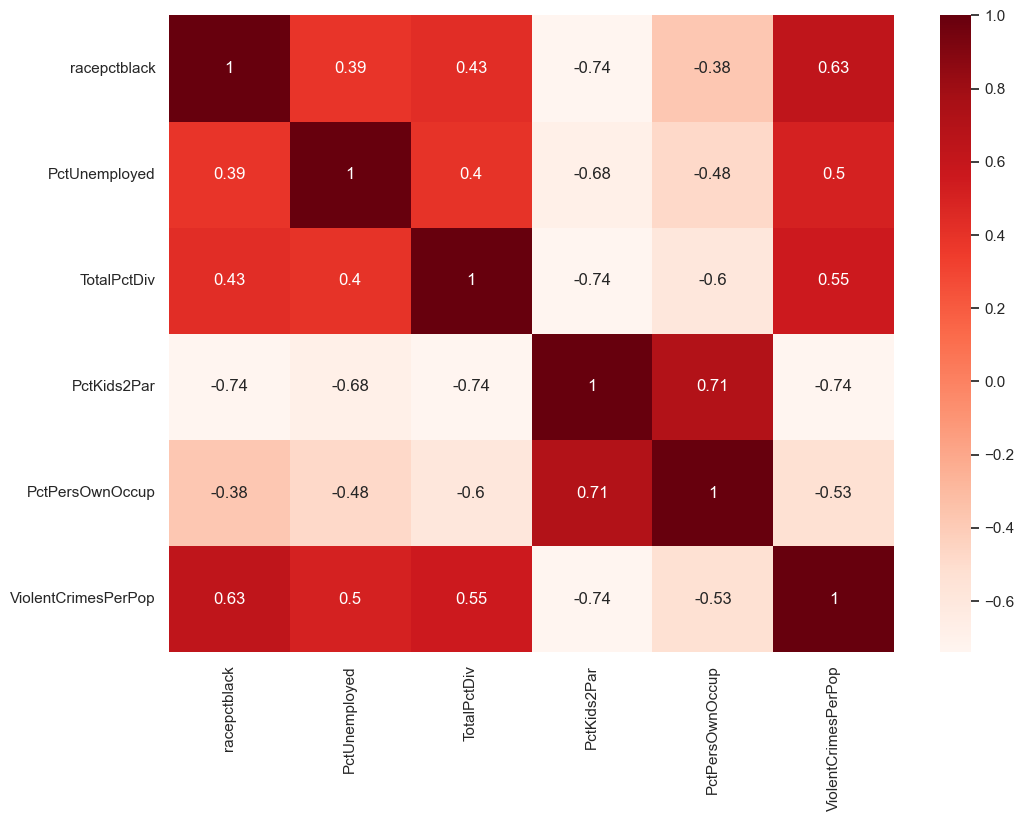

In [9]:
new_df = df[relevant_features.index].drop(["racePctWhite",
                                           "PctFam2Par",
                                           "PctYoungKids2Par",
                                           "PctTeen2Par",
                                           "PctIlleg",
                                           "MalePctDivorce",
                                           "FemalePctDiv",
                                           "pctWInvInc",
                                           "pctWPubAsst",
                                           "PctPopUnderPov",
                                        ], axis="columns")
new_cor = new_df.corr(method="pearson")
sns.heatmap(new_cor, annot=True, cmap=plt.cm.Reds)
plt.show()

This is good enough for now.

## Fitting models & Fairness measurements

In order to use classification-based fairness metrics, let's turn the predicted target values into a binary variable lowCrimeRate, which is 1 if ViolentCrimesPerPop is in its lower half (below 0.15) and 0 if not. Additionally, to create two groups based on racial demographics, let's create variable highPctBlack, which is 1 if racepctblack > 0.2.

### Linear regression

In [10]:
from aif360.metrics import ClassificationMetric
from aif360.datasets import StandardDataset

In [11]:
def get_train_test_set(data, ratio=0.3, seed=0):
    from sklearn.model_selection import train_test_split
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    return train_test_split(X, y, test_size = ratio, random_state = seed)

In [43]:
X_train, X_test, y_train, y_test = get_train_test_set(new_df)

model = LinearRegression(fit_intercept=True)

model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_test[y_pred_test < 0] = 0
nrp = X_test.shape[1]+1
rms = np.sqrt(sum((y_test-y_pred_test)**2)/(len(y_test)-nrp))

print('R^2: %.4f' % r2_score(y_test,y_pred_test))
print('MSE: %.4f' % mean_squared_error(y_test,y_pred_test))
print('MAE: %.4f' % mean_absolute_error(y_test,y_pred_test))
print('rms: %.4f' % rms)

R^2: 0.5689
MSE: 0.0231
MAE: 0.1096
rms: 0.1528


In [92]:
all_y = y.values.T[0]
midpoint = np.partition(all_y, int(len(all_y)/2))[int(len(all_y)/2)]
print(midpoint)
print()

def calculate_fairness_metrics(X_test_orig, y_test_orig, y_pred_test_orig):
    X_test = copy.deepcopy(X_test_orig)
    y_test = copy.deepcopy(y_test_orig)
    y_pred_test = copy.deepcopy(y_pred_test_orig)

    y_true_classes = np.array(y_test<midpoint).astype(int)
    y_pred_classes = np.array(y_pred_test<midpoint).astype(int)
    X_test["lowCrimeRate"] = y_true_classes
    X_test["highPctBlack"] = np.where(X_test['racepctblack'] < 0.2, 0.0, 1.0)

    accuracy = np.sum(y_true_classes==y_pred_classes)/len(y_true_classes)
    print("Accuracy of predicted 'classes':")
    print(accuracy, "\n")

    true_dataset = StandardDataset(X_test, label_name="lowCrimeRate", favorable_classes=[1],
                    protected_attribute_names=["highPctBlack"],
                    privileged_classes=[[0]],
                    instance_weights_name=None)

    X_pred = copy.deepcopy(X_test)
    X_pred["lowCrimeRate"] = y_pred_classes

    pred_dataset = StandardDataset(X_pred, label_name="lowCrimeRate", favorable_classes=[1],
                    protected_attribute_names=["highPctBlack"],
                    privileged_classes=[[0]],
                    instance_weights_name=None)

    metric = ClassificationMetric(true_dataset, pred_dataset, privileged_groups=[{"highPctBlack":0}], unprivileged_groups=[{"highPctBlack":1}])
    print("Average odds difference/equality of odds")
    print("Average of the difference in FPR and TPR for the unprivileged and privileged groups:")
    print(metric.average_odds_difference(), "\n")
    print("False negative rate ratio:")
    print(metric.false_negative_rate_ratio())

0.15



In [45]:
calculate_fairness_metrics(X_test, y_test, y_pred_test)

Accuracy of predicted 'classes':
0.7813021702838063 

Average odds difference/equality of odds
Average of the difference in FPR and TPR for the unprivileged and privileged groups:
-0.2939158995441952 

False negative rate ratio:
2.233333333333333


### Kernel ridge regression (KRR)

In [56]:
from sklearn.kernel_ridge import KernelRidge

X_train, X_test, y_train, y_test = get_train_test_set(df)
krr = KernelRidge(kernel="rbf", alpha=1.0, gamma=0.05)
krr.fit(X_train.drop(["racepctblack"], axis="columns"), y_train)

y_pred_test = krr.predict(X_test.drop(["racepctblack"], axis="columns"))
y_pred_test[y_pred_test < 0] = 0
nrp = X_test.shape[1]+1
rms = np.sqrt(sum((y_test-y_pred_test)**2)/(len(y_test)-nrp))

print('R^2: %.4f' % r2_score(y_test,y_pred_test))
print('MSE: %.4f' % mean_squared_error(y_test,y_pred_test))
print('MAE: %.4f' % mean_absolute_error(y_test,y_pred_test))
print('rms: %.4f' % rms)

R^2: 0.6474
MSE: 0.0189
MAE: 0.0939
rms: 0.1508


In [57]:
calculate_fairness_metrics(X_test, y_test, y_pred_test)

Accuracy of predicted 'classes':
0.8347245409015025 

Average odds difference/equality of odds
Average of the difference in FPR and TPR for the unprivileged and privileged groups:
-0.23756802651252557 

False negative rate ratio:
2.392857142857143


## Implementing fair ML

We will try two approaches: preprocessing by editing the training data and inprocessing by grid search to minimize a given fairness metric.

### Preprocessing

Here, we compare two preprocessing methods, learning fair representations and disparate impact remover. Learning fair representations works by encoding the data in a way that obfuscates the protected attributes, and disparate impact remover edits feature values to increase group fairness while preserving rank-ordering within groups.

#### Linear Regression

First, trying out learning fair representations.

In [94]:
from aif360.algorithms.preprocessing import LFR, DisparateImpactRemover

X_train, X_test, y_train, y_test = get_train_test_set(df)

y_classes = np.array(y_train<midpoint).astype(int)
X_train["lowCrimeRate"] = y_classes
X_train["highPctBlack"] = np.where(X_train['racepctblack'] < 0.2, 0.0, 1.0)

X_dataset = StandardDataset(X_train, label_name="lowCrimeRate", favorable_classes=[1],
                protected_attribute_names=["highPctBlack"],
                privileged_classes=[[0]],
                instance_weights_name=None)

lfr = LFR(unprivileged_groups=({"highPctBlack": 1},), 
          privileged_groups=({"highPctBlack": 0},),
          seed=0)

fair_X_train = lfr.fit_transform(X_dataset)

# fit model
fair_X_train = fair_X_train.features[:,:-1] # remove "highPctBlack" used for privileged classes
lr = LinearRegression(fit_intercept=True)
lr.fit(fair_X_train, y_train)

y_pred_test = lr.predict(X_test)
y_pred_test[y_pred_test < 0] = 0
nrp = X_test.shape[1]+1
rms = np.sqrt(sum((y_test-y_pred_test)**2)/(len(y_test)-nrp))

print('R^2: %.4f' % r2_score(y_test,y_pred_test))
print('MSE: %.4f' % mean_squared_error(y_test,y_pred_test))
print('MAE: %.4f' % mean_absolute_error(y_test,y_pred_test))
print('rms: %.4f' % rms)

calculate_fairness_metrics(X_test, y_test, y_pred_test)

R^2: -62574147764510159833621594112.0000
MSE: 3357400541696027776342032384.0000
MAE: 14702221776616.2812
rms: 63547770420791.7500
Accuracy of predicted 'classes':
0.5108514190317195 

Average odds difference/equality of odds
Average of the difference in FPR and TPR for the unprivileged and privileged groups:
-0.016297150555685758 

False negative rate ratio:
0.7282608695652174


/home/homm/DS/tml/tml-venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


The model breaks completely. Linear regression might be too simple of a model to be able to fit into the transformed data.

Next, let's try disparate impact remover.

In [95]:
dir = DisparateImpactRemover(1, "highPctBlack")
fair_X_train = dir.fit_transform(X_dataset)

# fit model
fair_X_train = fair_X_train.features[:,:-1] # remove "highPctBlack" used for privileged classes
lr = LinearRegression(fit_intercept=True)
lr.fit(fair_X_train, y_train)

y_pred_test = lr.predict(X_test)
y_pred_test[y_pred_test < 0] = 0
nrp = X_test.shape[1]+1
rms = np.sqrt(sum((y_test-y_pred_test)**2)/(len(y_test)-nrp))

print('R^2: %.4f' % r2_score(y_test,y_pred_test))
print('MSE: %.4f' % mean_squared_error(y_test,y_pred_test))
print('MAE: %.4f' % mean_absolute_error(y_test,y_pred_test))
print('rms: %.4f' % rms)

calculate_fairness_metrics(X_test, y_test, y_pred_test)

R^2: 0.5901
MSE: 0.0220
MAE: 0.1086
rms: 0.1626
Accuracy of predicted 'classes':
0.7829716193656093 

Average odds difference/equality of odds
Average of the difference in FPR and TPR for the unprivileged and privileged groups:
-0.33285481276253465 

False negative rate ratio:
2.521505376344086


/home/homm/DS/tml/tml-venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


#### Kernel Ridge Regression

In [82]:
X_train, X_test, y_train, y_test = get_train_test_set(df)

y_classes = np.array(y_train<midpoint).astype(int)
X_train["lowCrimeRate"] = y_classes
X_train["highPctBlack"] = np.where(X_train['racepctblack'] < 0.2, 0.0, 1.0)

X_dataset = StandardDataset(X_train, label_name="lowCrimeRate", favorable_classes=[1],
                protected_attribute_names=["highPctBlack"],
                privileged_classes=[[0]],
                instance_weights_name=None)

lfr = LFR(unprivileged_groups=({"highPctBlack": 1},), 
          privileged_groups=({"highPctBlack": 0},),
          seed=0)

fair_X_train = lfr.fit_transform(X_dataset)

# fit model
fair_X_train = fair_X_train.features[:,:-1] # remove "highPctBlack" used for privileged classes
krr = KernelRidge(kernel="rbf", alpha=1.0, gamma=0.05)
krr.fit(fair_X_train, y_train)

y_pred_test = krr.predict(X_test)
y_pred_test[y_pred_test < 0] = 0
nrp = X_test.shape[1]+1
rms = np.sqrt(sum((y_test-y_pred_test)**2)/(len(y_test)-nrp))

print('R^2: %.4f' % r2_score(y_test,y_pred_test))
print('MSE: %.4f' % mean_squared_error(y_test,y_pred_test))
print('MAE: %.4f' % mean_absolute_error(y_test,y_pred_test))
print('rms: %.4f' % rms)

calculate_fairness_metrics(X_test, y_test, y_pred_test)


R^2: -0.2354
MSE: 0.0663
MAE: 0.1667
rms: 0.2824
Accuracy of predicted 'classes':
0.6176961602671118 

Average odds difference/equality of odds
Average of the difference in FPR and TPR for the unprivileged and privileged groups:
0.08758632392335136 

False negative rate ratio:
0.0


/home/homm/DS/tml/tml-venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KernelRidge was fitted without feature names
  warnings.warn(


In [98]:
dir = DisparateImpactRemover(1, "highPctBlack")
fair_X_train = dir.fit_transform(X_dataset)

# fit model
fair_X_train = fair_X_train.features[:,:-1] # remove "highPctBlack" used for privileged classes
krr = KernelRidge(kernel="rbf", alpha=1.0, gamma=0.05)
krr.fit(fair_X_train, y_train)

y_pred_test = krr.predict(X_test)
y_pred_test[y_pred_test < 0] = 0
nrp = X_test.shape[1]+1
rms = np.sqrt(sum((y_test-y_pred_test)**2)/(len(y_test)-nrp))

print('R^2: %.4f' % r2_score(y_test,y_pred_test))
print('MSE: %.4f' % mean_squared_error(y_test,y_pred_test))
print('MAE: %.4f' % mean_absolute_error(y_test,y_pred_test))
print('rms: %.4f' % rms)

calculate_fairness_metrics(X_test, y_test, y_pred_test)

R^2: 0.6243
MSE: 0.0202
MAE: 0.1022
rms: 0.1557
Accuracy of predicted 'classes':
0.7963272120200334 

Average odds difference/equality of odds
Average of the difference in FPR and TPR for the unprivileged and privileged groups:
-0.23173082032787995 

False negative rate ratio:
2.0180722891566263


/home/homm/DS/tml/tml-venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KernelRidge was fitted without feature names
  warnings.warn(


### Inprocessing

Grid search reduction is chosen because it has an available implementation in AIF360 that works for regression models as well (most methods can only do classification). As the fairness constraint, we use bounded group loss from Fairlearn, also because it works for regression models.

#### Linear regression

In [59]:
from aif360.algorithms.inprocessing import GridSearchReduction
from fairlearn.reductions import BoundedGroupLoss, ZeroOneLoss
from aif360.datasets import RegressionDataset

def train_fair_model(model, dataframe, drop_prot_attr):
    X_train, X_test, y_train, y_test = get_train_test_set(dataframe)

    bgl = BoundedGroupLoss(ZeroOneLoss())
    fair_model = GridSearchReduction(model, constraints=bgl, prot_attr="racepctblack", drop_prot_attr=drop_prot_attr)

    #format datasets
    train_df = pd.concat([X_train, y_train], axis="columns")
    train_dataset = RegressionDataset(train_df,
                                    dep_var_name="ViolentCrimesPerPop",
                                    protected_attribute_names=["racepctblack"],
                                    privileged_classes=[lambda x: x<0.2])
    train_df = pd.concat([X_test, y_test], axis="columns")
    test_dataset = RegressionDataset(train_df,
                                    dep_var_name="ViolentCrimesPerPop",
                                    protected_attribute_names=["racepctblack"],
                                    privileged_classes=[lambda x: x<0.2])

    # fit model and get predictions
    fair_model.fit(train_dataset)
    y_pred_dataset = fair_model.predict(test_dataset)
    y_pred_test = y_pred_dataset.labels.T[0]
    y_pred_test[y_pred_test < 0] = 0
    nrp = X_test.shape[1]+1
    rms = np.sqrt(sum((y_test-y_pred_test)**2)/(len(y_test)-nrp))

    print('R^2: %.4f' % r2_score(y_test,y_pred_test))
    print('MSE: %.4f' % mean_squared_error(y_test,y_pred_test))
    print('MAE: %.4f' % mean_absolute_error(y_test,y_pred_test))
    print('rms: %.4f' % rms)
    print()

    # calculate fairness
    calculate_fairness_metrics(X_test, y_test, y_pred_test)


model = LinearRegression(fit_intercept=True)
print("WITH PROTECTED ATTRIBUTE KEPT:\n")
train_fair_model(model, new_df, False)
print()
print("WITH PROTECTED ATTRIBUTE DROPPED:\n")
train_fair_model(model, new_df, True)
print()

print("WITH ALL DATA:\n")
train_fair_model(model, df, True)

WITH PROTECTED ATTRIBUTE KEPT:

R^2: 0.5678
MSE: 0.0232
MAE: 0.1136
rms: 0.1531

Accuracy of predicted 'classes':
0.7846410684474123 

Average odds difference/equality of odds
Average of the difference in FPR and TPR for the unprivileged and privileged groups:
-0.28397030565734205 

False negative rate ratio:
2.1676470588235293

WITH PROTECTED ATTRIBUTE DROPPED:

R^2: 0.5481
MSE: 0.0242
MAE: 0.1154
rms: 0.1565

Accuracy of predicted 'classes':
0.7562604340567612 

Average odds difference/equality of odds
Average of the difference in FPR and TPR for the unprivileged and privileged groups:
-0.16690537340003334 

False negative rate ratio:
1.4495192307692308

WITH ALL DATA:

R^2: 0.5735
MSE: 0.0229
MAE: 0.1143
rms: 0.1659

Accuracy of predicted 'classes':
0.7495826377295493 

Average odds difference/equality of odds
Average of the difference in FPR and TPR for the unprivileged and privileged groups:
-0.16977264712205276 

False negative rate ratio:
1.4823008849557522


#### Kernel ridge regression

In [52]:
krr = KernelRidge(kernel="rbf", alpha=1.0, gamma=0.05)

print("WITH PROTECTED ATTRIBUTE KEPT:\n")
train_fair_model(krr, df, False)
print()
print("WITH PROTECTED ATTRIBUTE DROPPED:\n")
train_fair_model(krr, df, True)

WITH PROTECTED ATTRIBUTE KEPT:

R^2: 0.6382
MSE: 0.0194
MAE: 0.0972
rms: 0.1528

Accuracy of predicted 'classes':
0.8146911519198664 

Average odds difference/equality of odds
Average of the difference in FPR and TPR for the unprivileged and privileged groups:
-0.2613619825697536 

False negative rate ratio:
2.392857142857143

WITH PROTECTED ATTRIBUTE DROPPED:

R^2: 0.6218
MSE: 0.0203
MAE: 0.1018
rms: 0.1562

Accuracy of predicted 'classes':
0.8063439065108514 

Average odds difference/equality of odds
Average of the difference in FPR and TPR for the unprivileged and privileged groups:
-0.18490016739413467 

False negative rate ratio:
1.7631578947368423
